# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Remote loading and model ensembles building of climate projection data in climate4R.

08/07/2021

**M. Iturbide** (Santander Meteorology Group. Institute of Physics of Cantabria, CSIC-UC, Santander, Spain).

This notebook describes the generation of two NetCDF data files that are included as [auxiliary material](./auxiliary-material) in this repository (`CMIP5_historical_pr.nc` and `CMIP5_rcp85_pr.nc`). These files contain precipitation climatologies of a reduced set of CMIP5 models for the 1986-2005 and 2041-2060 periods, respectively.

### Load libraries and functions

We will use the following climate4R libraries:
 * `loadeR` and `loadeR.2nc` to load and save data ([Iturbide et al., 2018](https://doi.org/10.1016/j.envsoft.2018.09.009))
 * `visualizeR` for data visualization ([Frías et al., 2018](https://doi.org/10.1016/j.envsoft.2017.09.008))
 
We will also need:
 * `devtools` to source remote R code (`source_url` function)

In [ ]:
library(loadeR)
library(loadeR.2nc)
library(visualizeR)
library(devtools)

### Parameter settings

Set custom parameters to be used below in this notebook. Enter here the variable, CMIP era, scenario and temporal and spatial scope of the analysis.

# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Bias adjustment of model temperatures for the calculation of extreme indices
29/6/2021

**A. Casanueva** ([Santander Meteorology Group](http://meteo.unican.es). Dept. Applied Mathematics and Compute Science, University of Cantabria, Santander, Spain)

Bias adjustment is used in the IPCC interactive Atlas for the calculation of absolute threshold-based indices, namely the number of days with maximum temperature above 35ºC (TX35) and above 40ºC (TX40), and the number of frost days (minimum temperature below 0ºC). More details about bias adjustment can be found in the Atlas chapter from the IPCC-AR6 (Cross-Chapter Box 10.2: "Issues in bias adjustment") and in [Casanueva et al. 2020](https://doi.org/10.1002/asl.978).

Among the wide variety of methods typically used by the climate community for bias adjustment, this notebook focuses on ISIMIP3 ([Lange 2019](https://doi.org/10.5194/gmd-12-3055-2019)), a parametric quantile mapping alternative which has been designed to robustly adjust biases in all percentiles of a distribution whilst preserving their trends. In particular, we use ISIMIP3 in this example to bias-adjust temperature from the r12i1p1 run of the EC-EARTH global climate model, included in the fifth phase of the Coupled Model Intercomparison Project (CMIP5), over the Iberian Peninsula using as reference the W5E5 observational dataset ([Cucchi et al. 2020](https://doi.org/10.5194/essd-12-2097-202)). We focus on the boreal summer season (June-July-August) for the calculation of bias-adjusted TX35.

### Loading packages
This notebook is based on the R programming language and requires the following [climate4R](https://github.com/SantanderMetGroup/climate4R) packages:

 * `loadeR` to load climate model and observational datasets ([Iturbide et al. 2019](https://doi.org/10.1016/j.envsoft.2018.09.009)).
 * `climate4R.UDG` to access harmonized climate data via the [Santander Meteorology Group UDG-TAP](http://meteo.unican.es/udg-tap/).
 * `transformeR` to manipulate climate data ([Iturbide et al. 2019](https://doi.org/10.1016/j.envsoft.2018.09.009)).
 * `downscaleR` to adjust systematic model biases ([Bedia et al. 2020](https://doi.org/10.5194/gmd-13-1711-2020)).
 * `climate4R.indices` to compute climate indices ([Iturbide et al. 2019](https://doi.org/10.1016/j.envsoft.2018.09.009)).
 * `visualizeR` to produce graphical representations of the results ([Frías et al. 2018](https://doi.org/10.1016/j.envsoft.2017.09.008)).
 
Along with:

 * `rgdal` to work with spatial data ([Bivand et al., 2018](https://CRAN.R-project.org/package=rgdal)).

In [ ]:
library(loadeR) 
library(climate4R.UDG) 
library(transformeR)
library(downscaleR)
library(climate4R.indices)
library(visualizeR)
library(rgdal)

### Defining the parameters of the experiment
We start by setting the general parameters that define the experiment to perform: spatial extent (Iberian Peninsula), season (June-July-August), baseline/historical period (1986-2005) and future period/emission scenario (2041-2060, RCP8.5) of interest. We set likewise the codes which identify the desired datasets in the [Santander Meteorology Group UDG-TAP](http://meteo.unican.es/udg-tap/) , here W5E5 and EC-EARTH (historical and RCP8.5). Check other available, harmonized datasets with `?UDG.datasets`.

In [ ]:
lons <- c(-9.25, 3.5)  # Iberian Peninsula
lats <- c(36, 44)   # Iberian Peninsula

season <- 6:8  # June-July-August
years.hist <- 1986:2005
years.rcp <- 2041:2060

dataset.obs <- "W5E5" 
dataset.hist <- "CMIP5_EC-EARTH_r12i1p1_historical"
dataset.rcp <- "CMIP5_EC-EARTH_r12i1p1_rcp85"

### Loading datasets 
Next, we will see two alternative ways to load in memory the datasets that are needed to run this experiment. On the one hand, both W5E5 and EC-EARTH can be accessed from the [Santander Meteorology Group UDG-TAP](http://meteo.unican.es/udg-tap/), a THREDDS-based service that provides access to a wide catalogue of popular climate datasets. On the other hand, for the sake of time, these data have been also stored locally as `NetCDF` files and can be directly loaded from the `auxiliary-material` folder. In both cases, the datasets can be easily accessed via the `loadGridData` function.

####  Online from the User Data Gateway - Thredds Access Portal (UDG-TAP)

> This section takes long to execute due to intensive remote data loading. See the next section ([From local files](#From-local-files)) to load these data from a local copy available in the repository and continue with the notebook operations.


Previously defined parameters are used to load daily observed (W5E5) and simulated (EC-EARTH) temperatures from the UDG-TAP. For EC-EARTH, both historical and future (i.e. RCP8.5) simulations are needed. It is important to note that not only mean, but also minimum and maximum temperatures are required by the ISIMIP3 method to adjust maximum and minimum temperature, which are obtained from the correction of the amplitude and skewness of the diurnal temperature cycle.

```R

load.data <- function (dset, years, var) loadGridData(dataset = dset, var = var,
                                                 years = years,
                                                 latLim = lats, lonLim = lons,
                                                 season = season) 
# Loading mean temperature
y.tas <- load.data(dataset.obs, years.hist, "tas")
x.tas <- load.data(dataset.hist, years.hist, "tas")
newdata.tas <- load.data(dataset.rcp, years.rcp, "tas")

# Loading minimum temperature
y.tasmin <- load.data(dataset.obs, years.hist, "tasmin")
x.tasmin <- load.data(dataset.hist, years.hist, "tasmin")
newdata.tasmin <- load.data(dataset.rcp, years.rcp, "tasmin")

# Loading maximum temperature
y.tasmax <- load.data(dataset.obs, years.hist, "tasmax")
x.tasmax <- load.data(dataset.hist, years.hist, "tasmax")
newdata.tasmax <- load.data(dataset.rcp, years.rcp, "tasmax")
```

Due to the spatial mismatch between model and observations, we upscale W5E5 from its original resolution (0.5º) to a 1º regular grid similar to that of EC-EARTH (1.125º). See [Casanueva et al. 2020](https://doi.org/10.1002/asl.978) for a discussion on this procedure. 

```R
upscale <- function(grid) redim(upscaleGrid(grid, times = 2, aggr.fun = list(FUN = "mean", na.rm = TRUE)), 
                                drop = TRUE)
y.tas <- upscale(y.tas)
y.tasmax <- upscale(y.tasmax)
y.tasmin <- upscale(y.tasmin)
```

In [2]:
var <- "pr"
project <- "CMIP5"
scenario <- "rcp85"
season <- c(12, 1, 2)
base.period <- 1986:2005
future.period <- 2041:2060
# Target region boundaries (Europe)
lonLim <- c(-10, 35)
latLim <- c(35, 75)

The season is a sequence of month numbers. Use `1:12` for the entire year. Boreal winter (DJF) is `season = c(12, 1, 2)` and so on.

### The Santander Climate Data Service

The [Santander Climate Data Service](https://www.scds.es) (SCDS) archives and provides access to a variety of climate datasets and contributes to international infrastructures, serving e.g. as data node for the Earth System Grid Federation (ESGF) or the IPCC Data Distribution Center (IPCC-DDC). This service is maintained by the [Santander Meteorology Group](http://meteo.unican.es) (University of Cantabria - CSIC) and includes a THREDDS Data Server for remote data access with seamless integration with the climate4R framework for climate data postprocessing. This integration, the User Data Gateway (UDG), is handled by the [climate4R.UDG](https://github.com/SantanderMetGroup/climate4R.UDG) package, loaded automatically by the [loadeR](https://github.com/SantanderMetGroup/loadeR) package, which provides user-friendly access to a variety of remote data sources.

### Extract and select the ensemble models

The function `UDG.datasets` returns the list of available datasets matching a pattern. Here the selected project and scenario is used as the search pattern (historical data is also listed).

In [3]:
dataset.hist <- UDG.datasets(paste0(project, ".*historical"))
dataset.scen <- UDG.datasets(paste0(project, ".*", scenario))

Matches found for: CMIP5_AR5_1run CMIP5_AR5 CMIP5_subset

Label names are returned, set argument full.info = TRUE to get more information

Matches found for: CMIP5_AR5_1run CMIP5_AR5 CMIP5_subset

Label names are returned, set argument full.info = TRUE to get more information



We select the set of models CMIP5_AR5_1run

In [4]:
dataset.hist <- dataset.hist[["CMIP5_AR5_1run"]]
dataset.scen <- dataset.scen[["CMIP5_AR5_1run"]]

Check the available models:

In [5]:
dataset.scen

[1] "CMIP5_ACCESS1-0_r1i1p1_rcp85"      "CMIP5_ACCESS1-3_r1i1p1_rcp85"     
 [3] "CMIP5_bcc-csm1-1-m_r1i1p1_rcp85"   "CMIP5_bcc-csm1-1_r1i1p1_rcp85"    
 [5] "CMIP5_BNU-ESM_r1i1p1_rcp85"        "CMIP5_CanESM2_r1i1p1_rcp85"       
 [7] "CMIP5_CCSM4_r1i1p1_rcp85"          "CMIP5_CESM1-BGC_r1i1p1_rcp85"     
 [9] "CMIP5_CMCC-CESM_r1i1p1_rcp85"      "CMIP5_CMCC-CM_r1i1p1_rcp85"       
[11] "CMIP5_CMCC-CMS_r1i1p1_rcp85"       "CMIP5_CNRM-CM5_r1i1p1_rcp85"      
[13] "CMIP5_CSIRO-Mk3-6-0_r1i1p1_rcp85"  "CMIP5_EC-EARTH_r1i1p1_rcp85"      
[15] "CMIP5_FGOALS-g2_r1i1p1_rcp85"      "CMIP5_GFDL-CM3_r1i1p1_rcp85"      
[17] "CMIP5_GFDL-ESM2G_r1i1p1_rcp85"     "CMIP5_GFDL-ESM2M_r1i1p1_rcp85"    
[19] "CMIP5_HadGEM2-CC_r1i1p1_rcp85"     "CMIP5_HadGEM2-ES_r1i1p1_rcp85"    
[21] "CMIP5_inmcm4_r1i1p1_rcp85"         "CMIP5_IPSL-CM5A-LR_r1i1p1_rcp85"  
[23] "CMIP5_IPSL-CM5A-MR_r1i1p1_rcp85"   "CMIP5_IPSL-CM5B-LR_r1i1p1_rcp85"  
[25] "CMIP5_MIROC-ESM-CHEM_r1i1p1_rcp85" "CMIP5_MIROC-ESM_r1i1p1_rcp85"     
[27] "CMIP5_MIROC5_r1i1p1_rcp85"         "CMIP5_MPI-ESM-LR_r1i1p1_rcp85"    
[29] "CMIP5_MPI-ESM-MR_r1i1p1_rcp85"     "CMIP5_MRI-CGCM3_r1i1p1_rcp85"     
[31] "CMIP5_NorESM1-M_r1i1p1_rcp85"

For brevity, we will only use the first 6 models. 

To ensure that we get the same ensemble of models for both the historical and the future scenario we define the model names as follows:

In [6]:
n.models <- 6
models <- gsub(paste0("_", scenario), "", dataset.scen[1:n.models])
models

[1] "CMIP5_ACCESS1-0_r1i1p1"    "CMIP5_ACCESS1-3_r1i1p1"   
[3] "CMIP5_bcc-csm1-1-m_r1i1p1" "CMIP5_bcc-csm1-1_r1i1p1"  
[5] "CMIP5_BNU-ESM_r1i1p1"      "CMIP5_CanESM2_r1i1p1"

Search the position of each model in `dataset.hist` and `dataset.ssp` using `grep` in a loop. Subsequently, use these positions to subset the corresponding datasets.

In [7]:
find.index <- function(target, all) vapply(target, grep, numeric(length = 1), x = all)
dataset.hist <- dataset.hist[find.index(models, dataset.hist)]
dataset.scen <- dataset.scen[find.index(models, dataset.scen)]
dataset.hist; dataset.scen

[1] "CMIP5_ACCESS1-0_r1i1p1_historical"   
[2] "CMIP5_ACCESS1-3_r1i1p1_historical"   
[3] "CMIP5_bcc-csm1-1-m_r1i1p1_historical"
[4] "CMIP5_bcc-csm1-1_r1i1p1_historical"  
[5] "CMIP5_BNU-ESM_r1i1p1_historical"     
[6] "CMIP5_CanESM2_r1i1p1_historical"

[1] "CMIP5_ACCESS1-0_r1i1p1_rcp85"    "CMIP5_ACCESS1-3_r1i1p1_rcp85"   
[3] "CMIP5_bcc-csm1-1-m_r1i1p1_rcp85" "CMIP5_bcc-csm1-1_r1i1p1_rcp85"  
[5] "CMIP5_BNU-ESM_r1i1p1_rcp85"      "CMIP5_CanESM2_r1i1p1_rcp85"

Now we are sure that the same models (in the same order) are selected for both scenarios.

### Load data

The original function for data loading is `loadGridData`. Here, `climatology` is applied in a `lapply` loop to perform the same operation on each model and return the list of climatologies. This data loading takes above 30 minutes.

In [8]:
load.dataset <- function(dataset.list, period){
    lapply(dataset.list, function(dataset) 
        climatology(loadGridData(dataset,
                var = var,
                years = period,
                season = season,
                lonLim = lonLim,
                latLim = latLim
        ))
    )
}

In [ ]:
hist <- load.dataset(dataset.hist, base.period)
scen <- load.dataset(dataset.scen, future.period)

### Build the ensemble 
Interpolate (function `interpGrid`) to the common grid available in this repository and build the ensemble (function `bindGrid`):

In [ ]:
common.grid <- loadGridData("../reference-grids/land_sea_mask_2degree.nc4", var = "sftlf", lonLim = lonLim, latLim = latLim)
interpolate <- function(grid.list) lapply(grid.list, function(i) interpGrid(i, getGrid(common.grid), method = "bilinear"))
build.ensemble <- function(grid.list, experiment){
    bindGrid(grid.list, dimension = "member", dataset.attr = sprintf("%s %s model subset", project, experiment))
}
hist.ens <- build.ensemble(interpolate(hist), "historical")
scen.ens <- build.ensemble(interpolate(scen), scenario)

The output is a climate4R grid of the precipitation climatology that includes the `member` dimension (i.e. a multi-member grid):

In [11]:
str(scen.ens)

List of 6
 $ Variable           :List of 2
  ..$ varName: chr "pr"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi TRUE
  ..- attr(*, "description")= chr "Precipitation"
  ..- attr(*, "units")= chr "mm"
  ..- attr(*, "longname")= chr "total precipitation amount"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
 $ Data               : num [1:6, 1, 1:21, 1:23] 1.552 1.15 NA 0.977 0.901 ...
  ..- attr(*, "dimensions")= chr [1:4] "member" "time" "lat" "lon"
 $ xyCoords           :List of 2
  ..$ x: num [1:23] -9 -7 -5 -3 -1 1 3 5 7 9 ...
  ..$ y: num [1:21] 35 37 39 41 43 45 47 49 51 53 ...
  ..- attr(*, "resX")= num 2
  ..- attr(*, "resY")= num 2
  ..- attr(*, "projection")= chr "LatLonProjection"
  ..- attr(*, "interpolation")= chr "bilinear"
 $ Dates              :List of 2
  ..$ start: chr "2040-12-01 12:00:00 GMT"
  ..$ end  : chr "2060-02-29 12:00:00 GMT"
  ..- attr(*, "season")= i

We can display the result using `spatialPlot`:

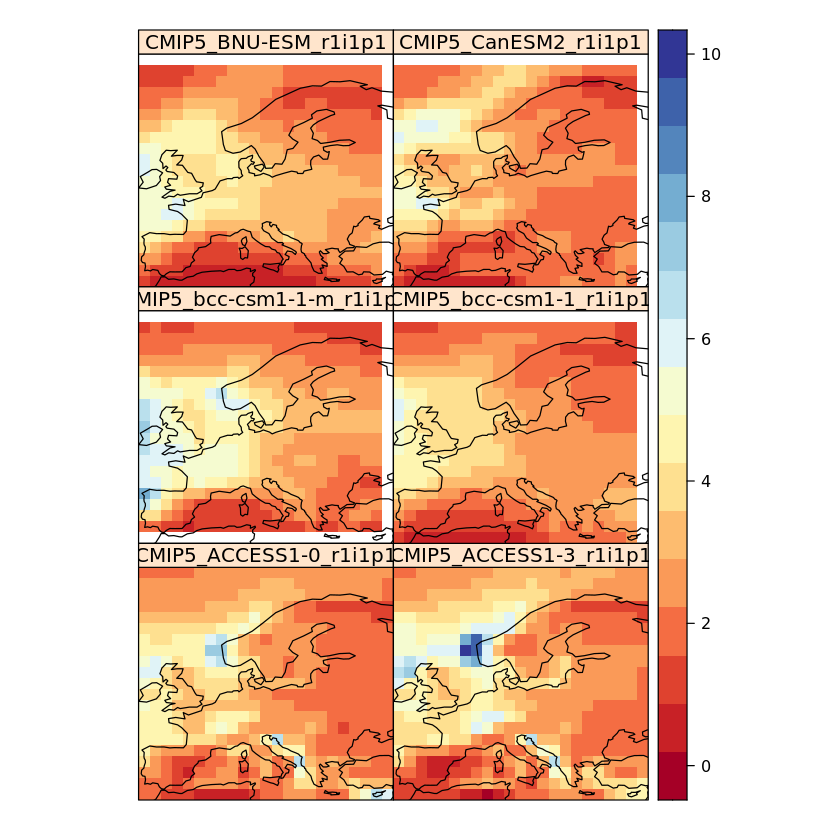

In [12]:
hist.ens$Members <- models
scen.ens$Members <- models
spatialPlot(scen.ens, backdrop.theme = "coastline", names.attr = models)

### Export to NetCDF

Finally, we can export these objects to NetCDF files for later use (see e.g. the [hatching-uncertainty](./hatching-uncertainty_R.ipynb) notebook).

In [13]:
grid2nc(hist.ens, sprintf("auxiliary-material/%s_historical_%s.nc", project, var))
grid2nc(scen.ens, sprintf("auxiliary-material/%s_%s_%s.nc", project, scenario, var))

[2021-07-22 18:37:05] NetCDF file written in: auxiliary-material/CMIP5_historical_pr.nc

[2021-07-22 18:37:05] NetCDF file written in: auxiliary-material/CMIP5_rcp85_pr.nc



### Session Information

In [14]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /srv/conda/envs/notebook/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] devtools_2.4.1      usethis_2.0.1       visualizeR_1.6.1   
[4] transformeR_2.1.2   loadeR.2nc_0.1.2    loadeR_1.7.1       
[7] climate4R.UDG_0.2.3 loadeR.java_1.1.1   rJava_1.0-4        

loaded via a namespace (and not attached):
 [1] CircStats_0.2-6         bitops_1.0-7  